In [23]:
import torch
import random
import numpy as np
from collections import deque
from simulation import Simulation, Data
from constants import *
from model import QNet, QTrainer
import matplotlib.pyplot as plt
import tqdm

In [24]:
MAX_MEMORY = 100_000 # max number of experiences we can store
LR = 0.001
GAMMA = 0.1 # discount rate

NUM_EPISODES = 200
LENGTH_EPISODES = 50

# if GPU is to be used
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:

class Agent:

    def __init__(self):
        self.n_games = 0
        self.gamma = GAMMA 
        self.memory = deque([], maxlen=MAX_MEMORY) # popleft()
        self.model = QNet(6*N_PM+5*N_APPS+N_APPS*N_PM, 512, N_APPS*N_PM).to(DEVICE)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

        # random control
        self.epsilon = 0 # randomness
        self.last_action_random = False
        self.last_action = None
        self.last_action_tick = 0


    def get_state(self, simulation: Simulation):
        return np.array(simulation.getState())

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state)) # popleft if MAX_MEMORY is reached

    def train_short_memory(self, state, action, reward, next_state):
        self.trainer.train_step(state, action, reward, next_state)

    def reset_memory(self):
        self.memory = deque([], maxlen=MAX_MEMORY)

    def train_long_memory(self):
        if len(self.memory) > LENGTH_EPISODES:
            mini_sample = random.sample(self.memory, LENGTH_EPISODES) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states)
        #for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = int((LENGTH_EPISODES*NUM_EPISODES)*0.7) - self.n_games # TODO change epsilon
        self.n_games += 1
        final_move = np.zeros(N_APPS*N_PM)

        if self.last_action_random and np.random.rand() < 0.8:
            final_move = self.last_action
            self.last_action_random = False
        elif random.randint(0, int((LENGTH_EPISODES*NUM_EPISODES)*0.7)) < self.epsilon:
            self.last_action_random = True
            for i in range(N_APPS):
                sum = 0
                for j in range(1,N_PM):
                    if np.random.rand() < 0.5:
                        final_move[i*N_PM+j] = 1
                        sum += 1
                if sum == 0:
                    continue
                for j in range(N_PM):
                    final_move[i*N_PM+j] /= sum     
        else:
            self.last_action_random = False
            state0 = torch.tensor(state, dtype=torch.float)
            final_move = self.model(state0).detach().numpy()
        
        self.last_action = final_move
        return final_move
    
    def get_model_action(self, state):

        state0 = torch.tensor(state, dtype=torch.float)
        final_move = self.model(state0).detach().numpy()
        return final_move



In [26]:
# training

class TrainingData:
    def __init__(self):
        self.rewards = []
        self.pm_usage = []
        self.requestsHistory = []
        self.pm_apps = []


def train(agent : Agent) -> TrainingData:
    trainingData = TrainingData()

    for _ in tqdm.tqdm(range(NUM_EPISODES)):
        
        simulation = Simulation()
        simulation.traceGenerator.tick = np.random.randint(0, 1000)
        agent.reset_memory()

        for _ in range(LENGTH_EPISODES):
            state_old = agent.get_state(simulation)

            # get move
            final_move = agent.get_action(state_old)

            # perform move and get new state
            reward, data = simulation.tick(final_move)
            state_new = agent.get_state(simulation)

            # train short memory
            agent.train_short_memory(state_old, final_move, reward, state_new)

            # remember
            agent.remember(state_old, final_move, reward, state_new)
                
            trainingData.rewards.append(reward)
            trainingData.pm_usage.append(data.pm_requests)
            trainingData.requestsHistory.append(data.requests)
            trainingData.pm_apps.append(data.pm_apps)
        
        agent.train_long_memory()

    return trainingData




In [27]:

agent = Agent()

trainingData = train(agent)

rewards = trainingData.rewards
pm_usage = trainingData.pm_usage
pm_apps = trainingData.pm_apps
requestsHistory = trainingData.requestsHistory



  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [04:09<00:00,  1.25s/it]


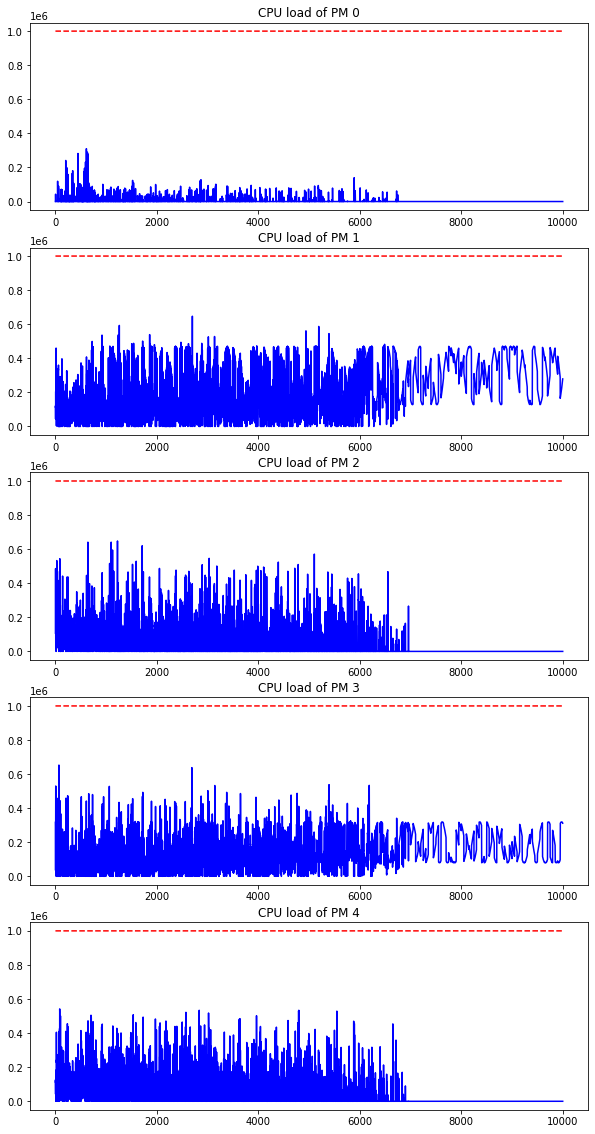

In [28]:
pm_usage = np.array(pm_usage)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Plot CPU load of PMs
for i in range(N_PM):
    axs[i].plot(pm_usage[:, i], 'b')
    axs[i].plot([1000000] * len(pm_usage), 'r--')
    axs[i].set_title(f'CPU load of PM {i}')


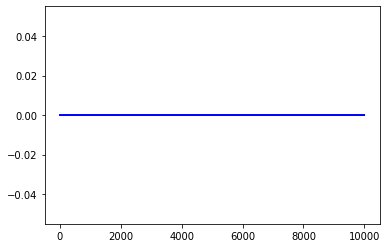

In [29]:

requestsHistory = np.array(requestsHistory)
plt.figure()
for i in range(N_APPS):
    plt.plot(requestsHistory[:,i], 'b')


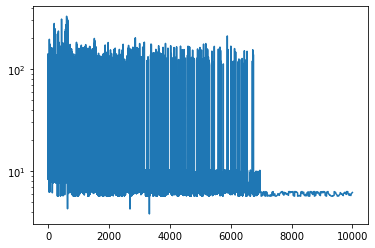

In [30]:

plt.figure()
plt.plot(-np.array(rewards))
plt.yscale('log')
plt.show()

In [31]:
# testing

rewards = []
pm_usage = []
pm_apps = []
requestsHistory = []
simulation = Simulation()
for _ in tqdm.tqdm(range(500)):
    # get old state
    state_old = agent.get_state(simulation)

    # get move
    final_move = agent.get_model_action(state_old)

    # perform move and get new state
    reward, data = simulation.tick(final_move)
    state_new = agent.get_state(simulation)

    # train short memory
    agent.train_short_memory(state_old, final_move, reward, state_new)

    # remember
    agent.remember(state_old, final_move, reward, state_new)

    # TODO make long term memory

    
    rewards.append(reward)
    pm_usage.append(data.pm_requests)
    requestsHistory.append(data.requests)
    pm_apps.append(data.pm_apps)



100%|██████████| 500/500 [00:16<00:00, 31.06it/s]


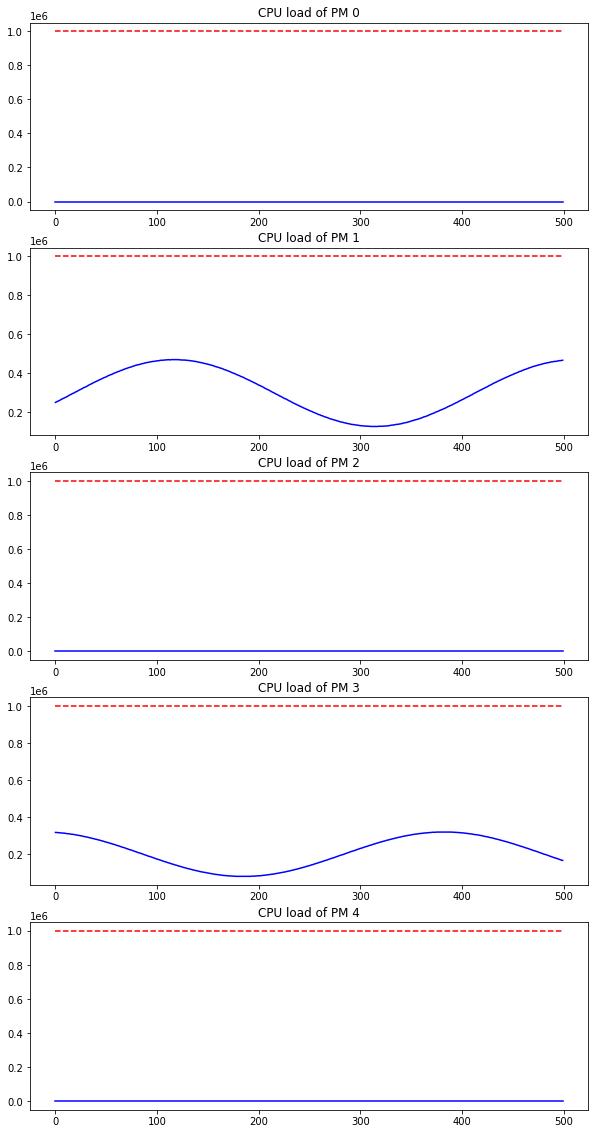

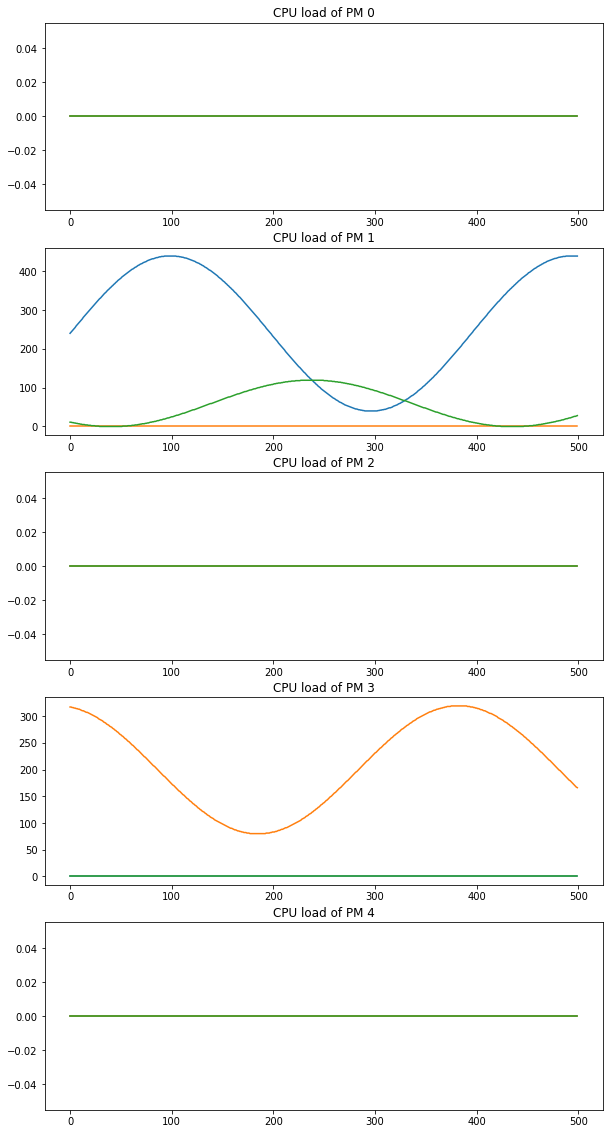

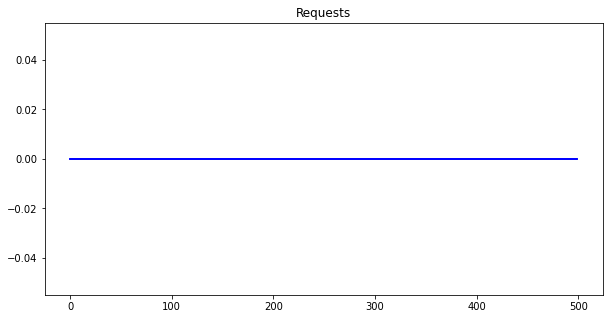

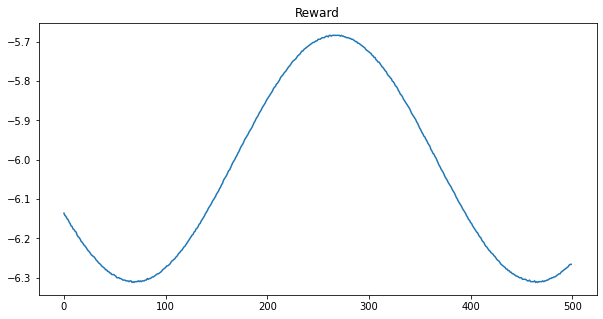

In [32]:
pm_usage = np.array(pm_usage)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Plot CPU load of PMs
for i in range(N_PM):
    axs[i].plot(pm_usage[:, i], 'b')
    axs[i].plot([1000000] * len(pm_usage), 'r--')
    axs[i].set_title(f'CPU load of PM {i}')

pm_apps = np.array(pm_apps)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Plot CPU load of PMs
for i in range(N_PM):
    axs[i].set_title(f'Requests for CPU {i}')
    for j in range(N_APPS):
        axs[i].plot(pm_apps[:, i, j])



requestsHistory = np.array(requestsHistory)
plt.figure(figsize=(10,5))
plt.title('Requests')
for i in range(N_APPS):
    plt.plot(requestsHistory[:,i], 'b')


plt.figure(figsize=(10,5))
plt.title('Reward')
plt.plot(rewards)
plt.show()